In [1]:
import os
import numpy as np
import pandas as pd

os.chdir("..")
from utils.utils import *
from shap_analysis.supporting_functions import *
from shap_analysis.plotting import *

os.chdir("..")
os.getcwd()

'/home/doro/Dokumente/Uni/Publication_Code/git_repo'

## Supplementary Information: Analysis of the LASSO model

#### Performance of LASSO model for large values of inverse alpha (SI figure 4)

In [2]:
df_lasso = pd.read_csv(f"data/output/benchmarking_lasso_large_alpha.csv", sep=";")

feature_list = list(df_lasso.columns)
for col_no_feat in [
    col_run_id,
    col_alpha,
    col_r2_train,
    col_r2_test,
    col_l2_train,
    col_l2_test,
    col_mse_train,
    col_mse_test,
    col_mae_train,
    col_mae_test,
    col_mape_train,
    col_mape_test,
]:
    feature_list.remove(col_no_feat)
df_lasso[col_count_non_zero] = (df_lasso[feature_list] != 0).sum(axis=1)
df_lasso_mean_perf = pd.DataFrame(df_lasso.groupby(by=col_alpha, as_index=False).mean())

x_max = 10100

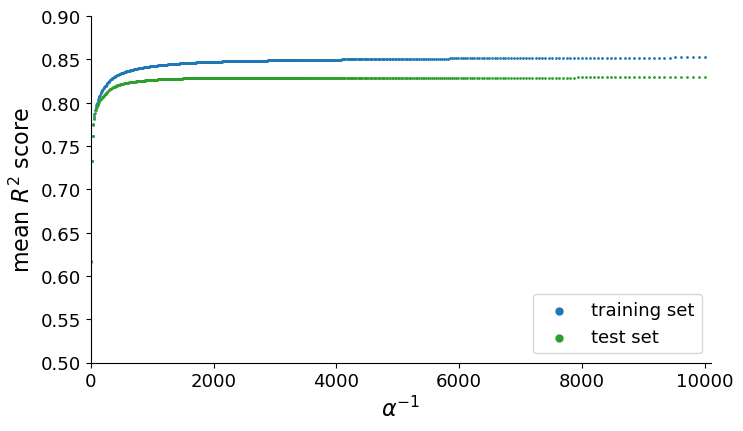

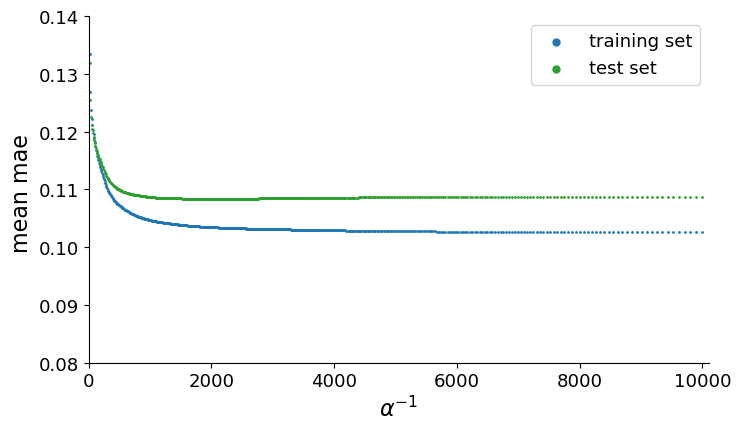

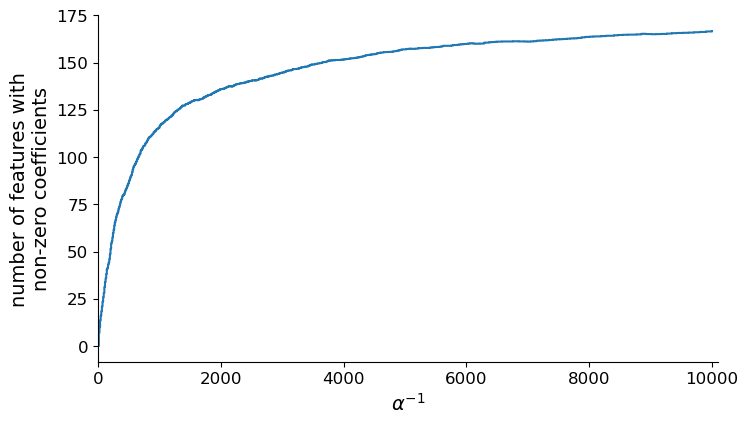

In [3]:
# figures of means over simulations based on different training-test-splits
# r2 score
fig, ax, leg = plot_performance_lasso(
    df_lasso_mean_perf,
    perf_metric_train=col_r2_train,
    perf_metric_test=col_r2_test,
    fig_size=(8, 4.5),
    y_min=0.5,
    y_max=0.9,
    x_max=x_max,
    threshold_inv_alpha=None,
)

# MAE
fig, ax, leg = plot_performance_lasso(
    df_lasso_mean_perf,
    perf_metric_train=col_mae_train,
    perf_metric_test=col_mae_test,
    fig_size=(8, 4.5),
    y_min=0.08,
    y_max=0.14,
    x_max=x_max,
    threshold_inv_alpha=None,
)

# number of non-zero coefficients
fig = plot_count_non_zero_coef(
    df_lasso_mean_perf, col_alpha, x_max=x_max, fig_size=(8, 4.5)
)

#### Performance and coefficients of LASSO model for small values of inverse alpha (SI figure 5)

In [4]:
df_lasso = pd.read_csv(f"data/output/benchmarking_lasso.csv", sep=";")

df_lasso[col_count_non_zero] = (df_lasso[feature_list] != 0).sum(axis=1)
df_lasso_mean_perf = pd.DataFrame(df_lasso.groupby(by=col_alpha, as_index=False).mean())

In [5]:
x_max = 44
threshold_inverse_alpha = 38

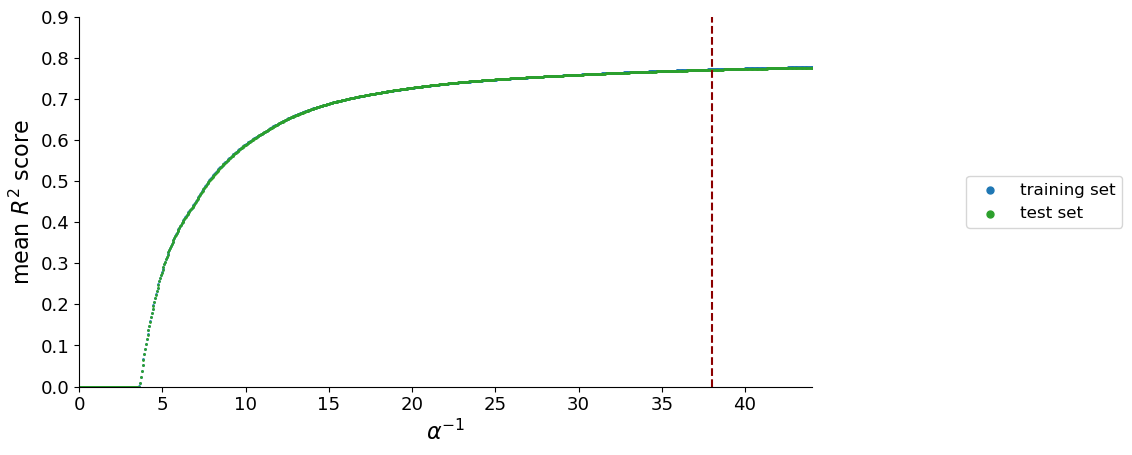

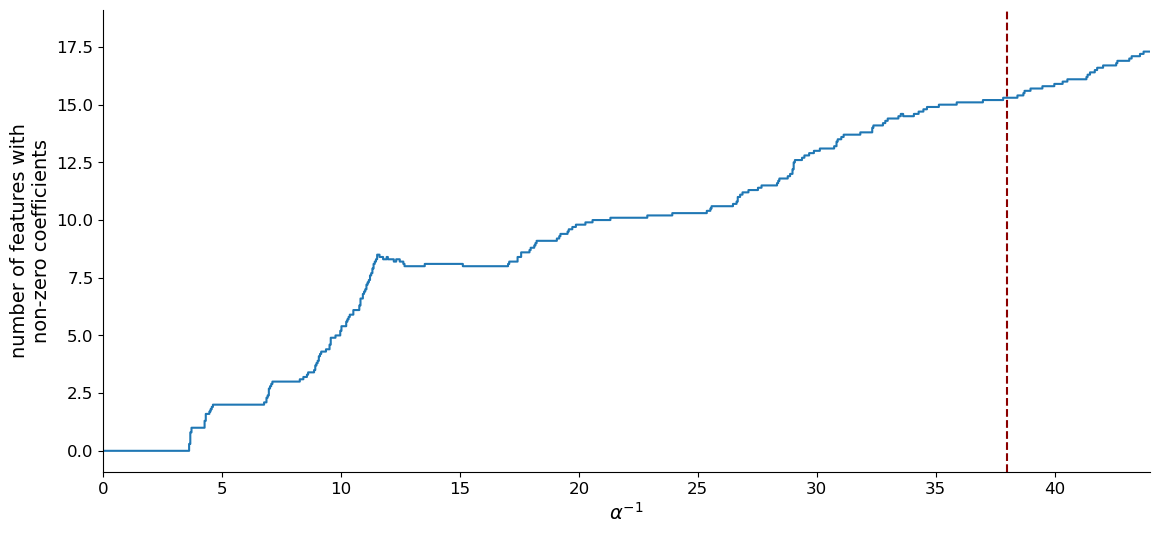

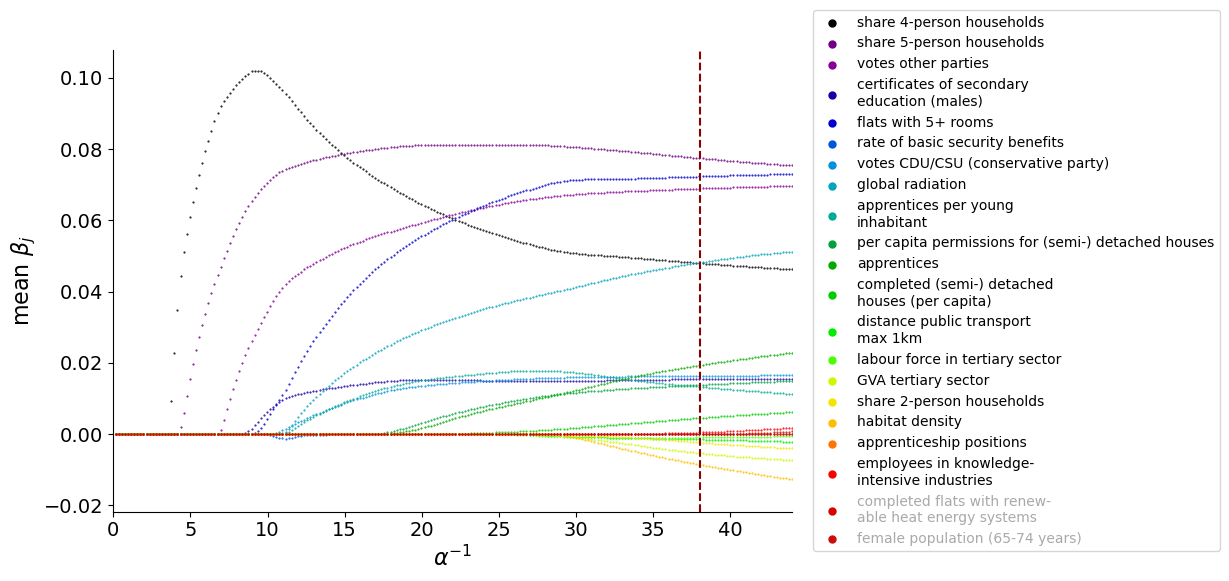

In [6]:
# r2 score
fig, ax, legend = plot_performance_lasso(
    df_lasso_mean_perf,
    perf_metric_train=col_r2_train,
    perf_metric_test=col_r2_test,
    x_max=x_max,
    fig_size=(1.5 * 9, 1.2 * 4),
    y_min=0,
    y_max=0.9,
    threshold_inv_alpha=threshold_inverse_alpha,
    pos_leg_in_figure=False,
)

# number of non-zero coefficients
fig = plot_count_non_zero_coef(
    df_lasso_input=df_lasso_mean_perf,
    col_alpha=col_alpha,
    threshold_inv_alpha=threshold_inverse_alpha,
    fig_size=(1.5 * 9, 1.5 * 4),
    x_max=x_max,
)

# Latex could not handle the original plot of coefficients as a tikzpicture due to the large number of datapoints. Thus, I dropped 750 of the total 1000 datapoints for each feature
df_lasso_mean_reduced = reduce_df_size(df=df_lasso_mean_perf, max_datapoints=250)

# mean coefficients
fig, legend = plot_mean_coefficients(
    df_lasso_mean_reduced,
    feature_list=feature_list,
    x_max=x_max,
    threshold_inv_alpha=threshold_inverse_alpha,
)

#### SHAP feature importances of LASSO model (SI Figure 6)

In [7]:
alpha_lasso = 0.026324

In [8]:
df_metadata = pd.read_csv(f"data/output/metadata_rfe.csv", sep=";")
df_metadata = prepare_metadata_dataframe(
    df_metadata, ["indices_training_set", "indices_val_set", "indices_test_set"]
)

df_data = pd.read_csv(df_metadata[col_file_path].unique()[0], sep=";")
df_data.loc[
    df_data["mean distance public transport"].isin([np.inf, -np.inf]),
    "mean distance public transport",
] = df_data.loc[
    ~df_data["mean distance public transport"].isin([np.inf, -np.inf]),
    "mean distance public transport",
].max()

# compute mean shap feature importances for all training-test-splits
df_mean_shap = pd.DataFrame()
df_std_shap = pd.DataFrame()
for split in df_metadata[col_run_id].unique():
    idx_train = df_metadata.loc[df_metadata[col_run_id] == split, col_idx_train].values[
        0
    ]
    idx_val = df_metadata.loc[df_metadata[col_run_id] == split, col_idx_val].values[0]
    df_mean_split = pd.DataFrame(
        df_data[feature_list].iloc[idx_train + idx_val].mean()
    ).T
    df_std_split = pd.DataFrame(
        df_data[feature_list].iloc[idx_train + idx_val].std(ddof=0)
    ).T
    df_coef = df_lasso.loc[
        (df_lasso[col_alpha] == alpha_lasso) & (df_lasso[col_run_id] == split),
        feature_list,
    ]
    # compute shap values of model
    df_shap = df_coef.iloc[0] * (
        (df_data[feature_list] - df_mean_split.iloc[0]) / df_std_split.iloc[0]
    )
    # compute shap feature importances and std of abs of shap values
    df_mean_shap_split = pd.DataFrame(df_shap.abs().mean(axis=0)).T
    df_std_shap_split = pd.DataFrame(df_shap.abs().std(ddof=0, axis=0)).T
    df_mean_shap = pd.concat([df_mean_shap, df_mean_shap_split])
    df_std_shap = pd.concat([df_std_shap, df_std_shap_split])
# compute mean shap feature importance over all training-test splits
df_fi = pd.DataFrame(
    {
        col_mean_shap: df_mean_shap[feature_list].mean(axis=0),
        col_std_shap: df_std_shap[feature_list].std(ddof=0, axis=0),
        col_occurences_feat: df_mean_shap[feature_list].astype(bool).sum(axis=0),
    }
)
df_fi = df_fi.loc[df_fi[col_mean_shap] != 0]
df_fi = df_fi.sort_values(col_mean_shap)

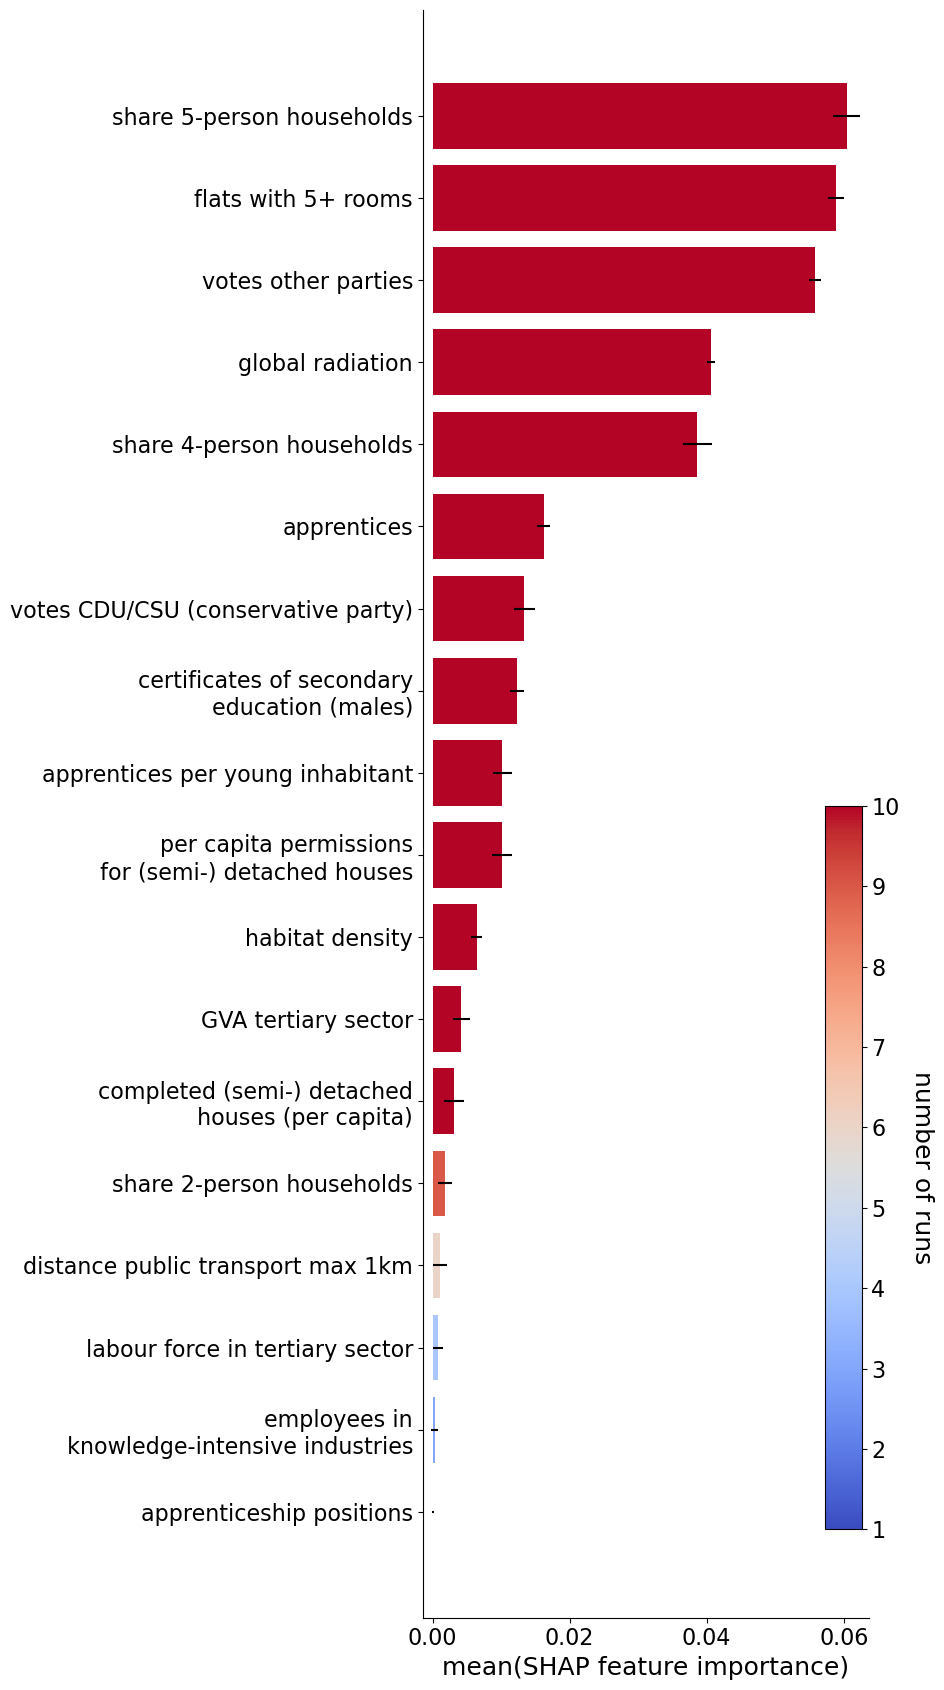

In [10]:
fig, ax = bar_shap_feature_imp(df_fi, df_fi.index)
plt.show()